In [299]:
import sys
sys.path.append("../code/")
from sklearn.metrics import mean_absolute_error
from dataloader import APPLIANCE_ORDER, get_train_test
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)


weight_appliance = {'mw':1, 'dw':1, 'dr':1,'fridge':1, 'hvac':1}

# num_hidden, num_iterations, num_layers, p, num_directions = sys.argv[1:6]


class CustomRNN(nn.Module):
    def __init__(self):
        super(CustomRNN, self).__init__()
        torch.manual_seed(0)

      
        self.lin_1 = nn.Linear(24, 100)
        self.lin_2 = nn.Linear(100, 24)
        self.bn = nn.BatchNorm1d(100)
        #self.lin_3 = nn.Linear(48, 24)
        
        
        self.act_1 = nn.ReLU()
        self.act_2 = nn.ReLU()
        #self.act_3 = nn.ReLU()

    def forward(self, x):
        
        pred = self.lin_1(x)
        pred = self.act_1(pred)
        pred = self.bn(pred)
        pred = self.lin_2(pred)
        pred = self.act_2(pred)
        
        
        #pred = torch.clamp(pred, min=0.)
        #pred = self.act(pred)
        pred = torch.min(pred, x)
        return pred


class AppliancesRNN(nn.Module):
    def __init__(self, num_appliance):
        super(AppliancesRNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomRNN().cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomRNN())

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        # print("Subtracting prediction")
        else:
            pass
        # print("Subtracting true")
        for appliance in range(self.num_appliance):
            # print(agg_current.mean().data[0])
            # print appliance
            # print self.order[appliance]
            # print args[2+appliance]
            #print(getattr(self, "Appliance_" + str(appliance)))
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

#ORDER = APPLIANCE_ORDER[1:][::-1]


num_hidden = 120
num_iterations = 300
num_layers = 1
num_directions = 1

input_dim = 1
hidden_size = num_hidden
num_layers = num_layers
if num_directions == 1:
    bidirectional = False
else:
    bidirectional = True
lr = 0.5
p = 0.1
num_folds = 5
fold_num = 0

torch.manual_seed(0)

train, test = get_train_test(num_folds=num_folds, fold_num=fold_num)
train_aggregate = train[:, 0, :, :].reshape(-1, 24)
test_aggregate = test[:, 0, :, :].reshape(-1, 24)

In [355]:
ORDER = APPLIANCE_ORDER[1:][:3]
ORDER = ['dw','fridge','dr','hvac']
#ORDER = ['fridge']
ORDER = ['dr']



In [356]:
out_train = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_train[a_num] = Variable(
        torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train_aggregate.shape[0], -1))))
    if cuda_av:
        out_train[a_num] = out_train[a_num].cuda()

out_test = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_test[a_num] = Variable(
        torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test_aggregate.shape[0], -1))))
    if cuda_av:
        out_test[a_num] = out_test[a_num].cuda()

loss_func = nn.L1Loss()
a = AppliancesRNN(num_appliance=len(ORDER))
#for param in a.parameters():
#    param.data = param.data.abs()
#print(a)
if cuda_av:
    a = a.cuda()
    loss_func = loss_func.cuda()
optimizer = torch.optim.Adam(a.parameters(), lr=lr)

In [357]:
inp = Variable(torch.Tensor(train_aggregate.reshape((train_aggregate.shape[0], -1))).type(torch.FloatTensor),
               requires_grad=True)

In [358]:
inp.size()

torch.Size([6048, 24])

In [359]:
for t in range(num_iterations):
    inp = Variable(torch.Tensor(train_aggregate), requires_grad=True)
    out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
    ot =  torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
    if cuda_av:
        inp = inp.cuda()
        out = out.cuda()
        ot = ot.cuda()

    params = [inp, p]
    for a_num, appliance in enumerate(ORDER):
        params.append(out_train[a_num])
    # print(params)
    pred = a(*params)

    optimizer.zero_grad()
    pred_split = torch.split(pred, pred.size(0)//len(ORDER))

    losses= [loss_func(pred_split[appliance_num], out_train[appliance_num])*weight_appliance[appliance] for appliance_num, appliance in enumerate(ORDER)]
    
    loss = sum(losses)
    if t % 1 == 0:
        print(t, loss.data[0])

    loss.backward()
    optimizer.step()

0 71.01615142822266
1 71.71507263183594
2 71.02389526367188
3 70.98837280273438
4 70.99422454833984
5 70.98822021484375
6 70.98696899414062
7 70.98731994628906
8 70.98587799072266
9 70.98418426513672
10 70.98307800292969
11 70.9820327758789
12 70.98078918457031
13 70.97882080078125
14 70.97679901123047
15 70.97408294677734
16 70.97042083740234
17 70.9656753540039
18 70.95758819580078
19 70.94902038574219
20 70.93312072753906
21 70.91990661621094
22 70.89867401123047
23 70.88154602050781
24 70.85111999511719
25 70.80989837646484
26 70.75402069091797
27 70.6901626586914
28 70.61727142333984
29 70.53768157958984
30 70.46672821044922
31 70.42635345458984
32 70.36323547363281
33 70.28582763671875
34 70.22908020019531
35 70.17931365966797
36 70.1313247680664
37 70.05289459228516
38 69.98223876953125
39 69.92361450195312
40 69.89187622070312
41 69.83277130126953
42 69.75379180908203
43 69.73538208007812
44 69.68329620361328
45 69.61744689941406
46 69.5364990234375
47 69.43103790283203
48 69.3

In [369]:
params = list(a.parameters())

In [370]:
params

[Parameter containing:
  -3.3506  -3.1879  -3.2470  ...   -3.1776  -2.8951  -3.1013
  -3.3245  -3.3450  -3.1336  ...   -3.3741  -3.2709  -3.2727
  -3.1569  -2.9114  -2.9423  ...   -3.0732  -2.9538  -3.1442
            ...               ⋱              ...            
  -9.3318   2.5198  -6.3060  ...   -3.4135   5.2826   3.0963
  -3.7275  -3.2698  -3.8527  ...   -2.2137  -3.7144  -3.7228
  -5.9317  -3.5109  15.1409  ...  -21.8608  -0.9601  27.5538
 [torch.FloatTensor of size 100x24], Parameter containing:
   0.5090
   1.9578
  -2.2550
  25.1550
  17.6602
  -6.7062
  -2.7133
  44.5314
  13.9788
  15.7237
 -13.5778
  21.1762
   5.5222
  -0.3901
   2.2207
  -2.1190
 -27.6682
 -10.5932
   0.0096
  -6.1415
  -1.3113
 -10.1889
  -0.3083
  -6.7284
  -0.8914
   1.3335
 -45.0526
  13.0050
 -19.4722
  -2.4791
   1.5511
  -1.5768
  44.5060
  46.7679
  18.4129
  -1.7793
  43.7034
   1.0512
  -2.6450
 -21.7115
   0.3294
  19.8194
  15.8737
 -15.1327
 -14.1337
  -5.7778
  40.7767
   6.7191
  -2.1619
 

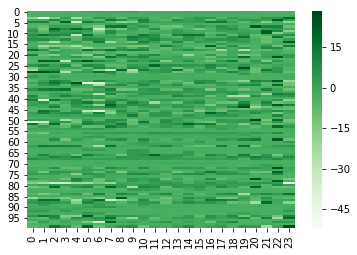

In [372]:
import seaborn as sns
sns.heatmap(params[0].data.numpy(),cmap='Greens')

array([[ 1.75242639,  1.97290468,  2.99824834, ...,  1.91621447,
         1.86813855,  1.92100716],
       [-3.19450808, -3.11893773, -2.96898532, ..., -3.16663551,
        -3.01404619, -3.06092381],
       [-3.15661907, -2.91101599, -2.94135237, ..., -3.0738709 ,
        -2.95394921, -3.1448822 ],
       ..., 
       [ 0.97504795, -3.83747602, -4.34702921, ..., -4.14243698,
        -2.06332207, -1.09633589],
       [-5.15804482, -5.09965658, -5.22449493, ..., -2.9059689 ,
        -5.03252888, -4.99857855],
       [ 2.27705932, -2.50385094,  1.06153262, ..., -0.62126249,
         1.1755203 ,  2.13903737]], dtype=float32)

In [323]:
pred.mean(dim=0)

Variable containing:
 193.5942
 171.5313
 149.8065
 136.0440
 126.4414
 124.2849
 130.2191
 129.0968
 149.3915
 162.3576
 210.0225
 263.2864
 284.9366
 332.9447
 389.9156
 432.1464
 457.2307
 463.2592
 412.8094
 384.7814
 382.2955
 343.0683
 281.7970
 231.0263
[torch.FloatTensor of size 24]

In [360]:
test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    test_inp = test_inp.cuda()

params = [test_inp, -2]
for i in range(len(ORDER)):
    params.append(None)
pr = a(*params)
pr = torch.clamp(pr, min=0.)
test_pred = torch.split(pr, test_aggregate.shape[0])
prediction_fold = [None for x in range(len(ORDER))]

if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].data.numpy().reshape(-1, 24)
gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(test_aggregate.shape[0], -1,
                                                                                         1).reshape(-1, 24)

In [361]:
ORDER

['dr']

In [363]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(prediction_fold[0], gt_fold[0])

51.263214717333433

In [365]:
prediction_fold[0].mean()

13.490524

In [313]:
%matplotlib inline

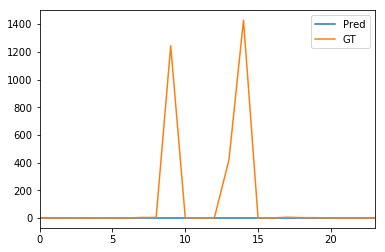

In [373]:
import matplotlib.pyplot as plt
pd.DataFrame(prediction_fold[0]).iloc[10].plot(label='Pred')
pd.DataFrame(gt_fold[0]).iloc[10].plot(label='GT')
plt.legend()

In [1]:



print([x.mean() for x in pred_split])
error = pd.Series({appliance:mean_absolute_error(gt_fold[appliance_num], prediction_fold[appliance_num]) for appliance_num, appliance in enumerate(ORDER)})

NameError: name 'cell_type' is not defined